In [1]:
# KNN Classifier (not the same as K-means - which is for unsupervised learning)
    # scaling is important for distance calculation
# In case of tie:
    # use odd value of K
    # reduce K by 1 until tie is broken
    # nearest neighbor <- this approach is followed by Scikit
# Tuning K
    # Elbow method - once error rate plateaus
    # Cross validation  
# PIPELINE

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

## Example - Gene Expression
* https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

In [3]:
path = '../../GitHub/Python-Data-Science/Data/'
df = pd.read_csv(path+'gene_expression.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [4]:
print(df['Cancer Present'].value_counts())
df.head()

1    1500
0    1500
Name: Cancer Present, dtype: int64


,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

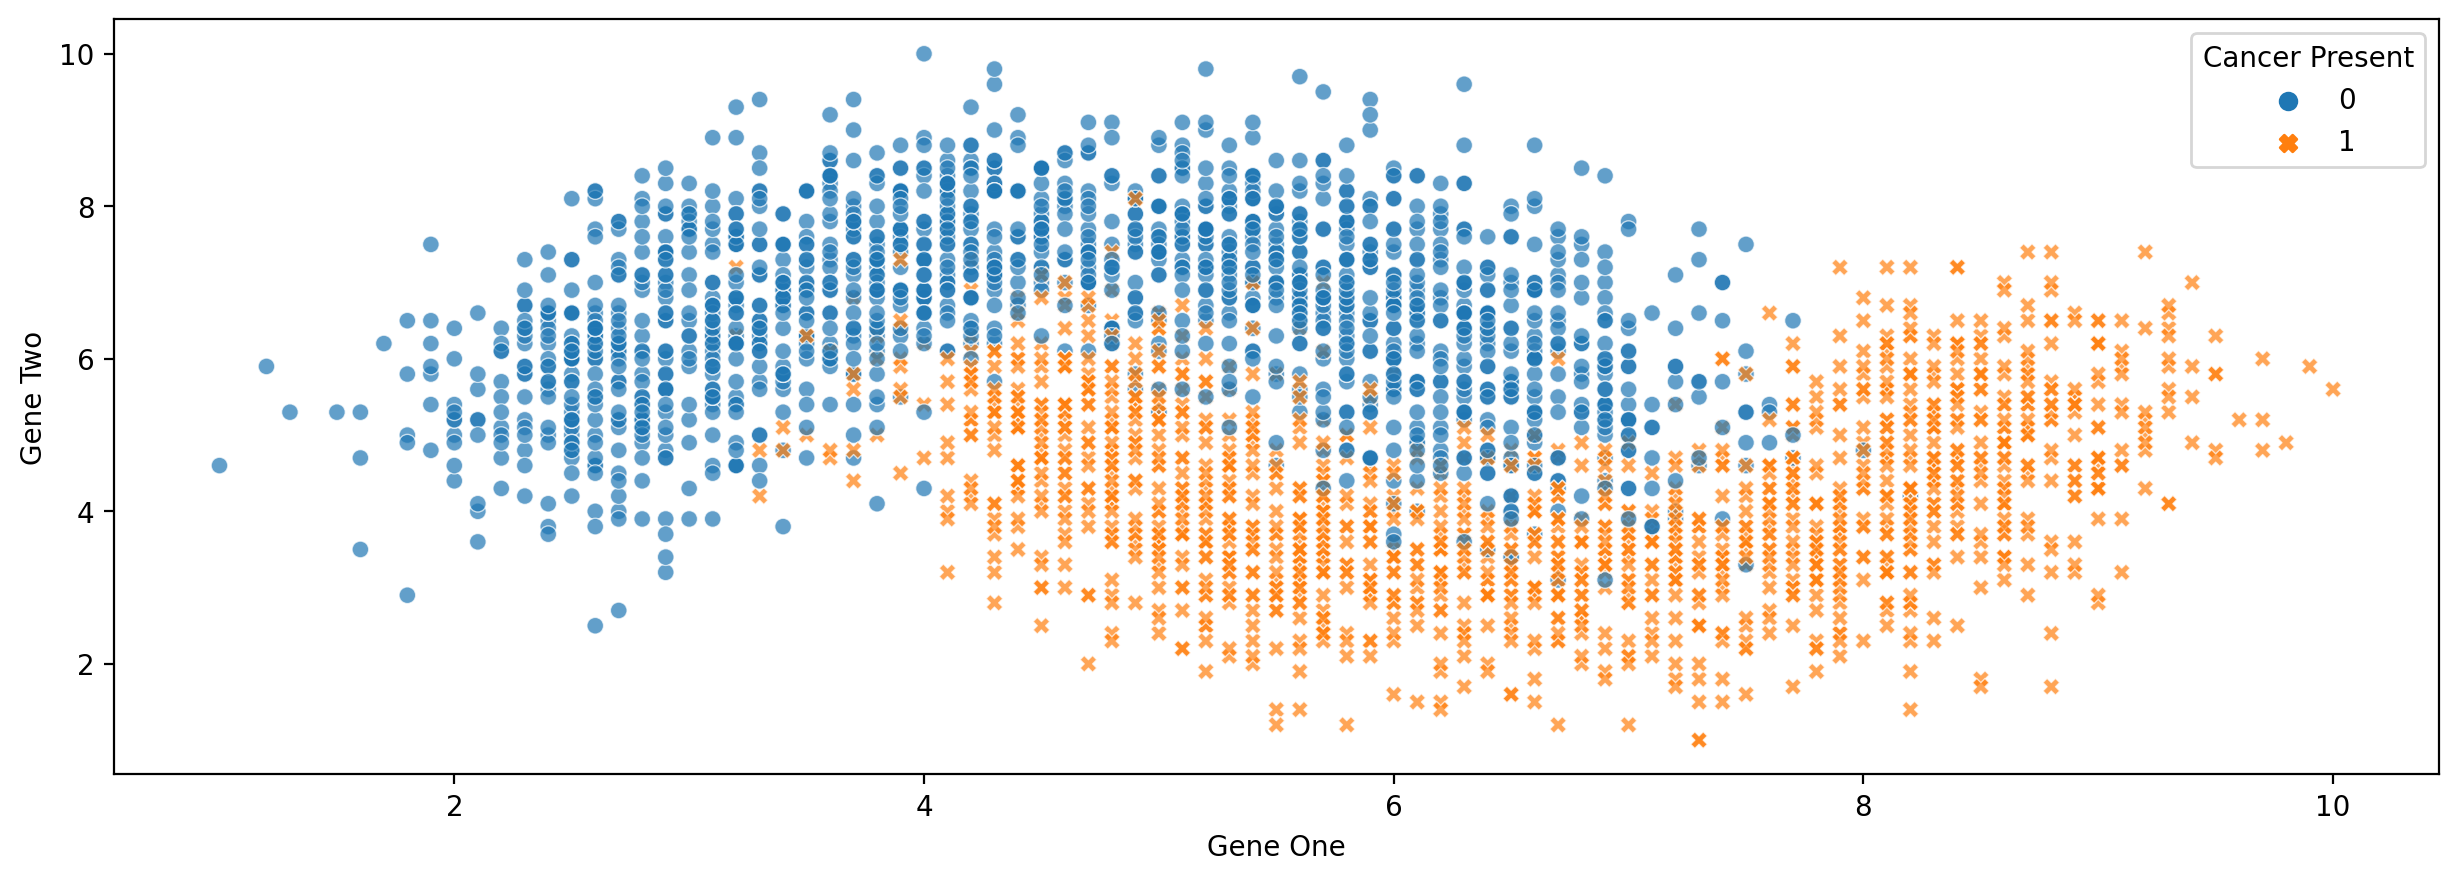

In [5]:
plt.figure(figsize=(15,5), dpi=200)
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.7, style='Cancer Present')

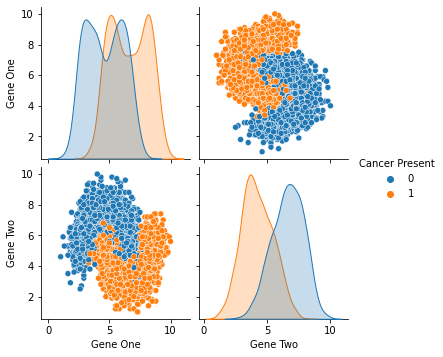

In [6]:
sns.pairplot(data=df, hue='Cancer Present')

In [7]:
X = df.drop(columns='Cancer Present')
y = df['Cancer Present']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

In [9]:
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n  = scaler.transform(X_test)

In [10]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of t

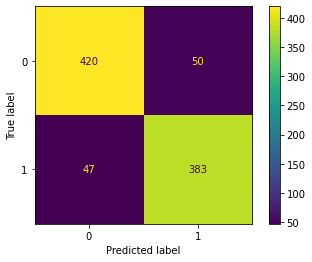

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train_n, y_train)
y_pred = knn_model.predict(X_test_n)

plot_confusion_matrix(knn_model, X_test_n, y_test)

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



[Text(0.5, 0, 'K-value'), Text(0, 0.5, 'Error Rate'), Text(0.5, 1.0, 'KNN')]

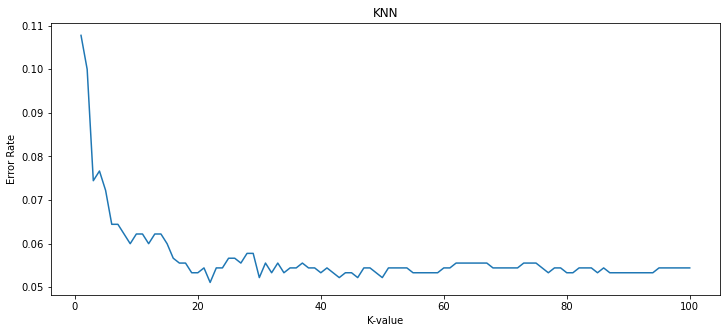

In [13]:
error_rate = []
for i in range(1,101):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(X_train_n, y_train)
    y_pred = knn_model.predict(X_test_n)
    error_rate.append(1-accuracy_score(y_test, y_pred))

plt.figure(figsize=(12,5))
sns.lineplot(x=range(1,101), y=error_rate).set(xlabel='K-value', ylabel='Error Rate', title='KNN')

### Pipeline - basic idea

In [14]:
# Setup ojects
scaler    = StandardScaler()

knn_model = KNeighborsClassifier()
knn_model.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [15]:
# Order in which they are performed. String names should be consistent
operations = [('scaler', scaler),
              ('knn_model', knn_model)]

from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)
# steps: List of (name, transform) tuples (implementing fit/transform) that are chained, 
# in the order in which they are chained, with the last object an estimator.

**Parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name

This let's scikit-learn know what operation in the pipeline these parameters are related to

In [16]:
k_values = list(range(1,20))

param_grid = {'knn_model__n_neighbors': k_values}

In [17]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

full_cv_classifier.fit(X_train, y_train)  

# Scaling is part of pipeline - knows how to fit/transform

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_model', KNeighborsClassifier())]),
             param_grid={'knn_model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19]},
             scoring='accuracy')

In [18]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn_model', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn_model': KNeighborsClassifier(n_neighbors=14),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn_model__algorithm': 'auto',
 'knn_model__leaf_size': 30,
 'knn_model__metric': 'minkowski',
 'knn_model__metric_params': None,
 'knn_model__n_jobs': None,
 'knn_model__n_neighbors': 14,
 'knn_model__p': 2,
 'knn_model__weights': 'uniform'}

In [19]:
# No need to scale test data explicitly - SCALING IS BUILT INTO PIPELINE
y_pred = full_cv_classifier.predict(X_test)

[[448  22]
 [ 34 396]]


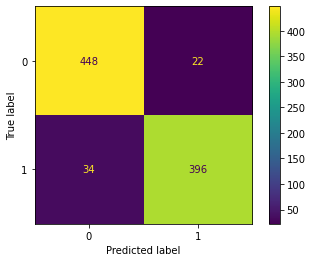

In [20]:
# Better performance for K=14, then before

print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(full_cv_classifier, X_test, y_test)

-----

## Example - Sonar-Mine dataset
* https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29

In [21]:
path = '../../GitHub/Python-Data-Science/Data/'
df = pd.read_csv(path+'sonar.all-data.csv')
#df.info()                             

In [22]:
df.head(5)

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [23]:
df['Label'].value_counts()             # balanced dataset

M    111
R     97
Name: Label, dtype: int64

In [24]:
df.columns[df.isna().sum() > 0]        # no-missing data

Index([], dtype='object')

<AxesSubplot:>

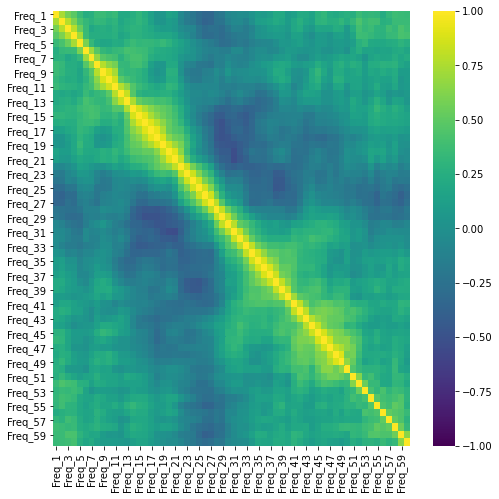

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), cmap='viridis', vmin=-1, vmax=1)

In [26]:
# Top frequencies correlated with Label
df['Label01'] = df['Label'].map({'R':0, 'M':1})
df.corr()['Label01'].abs().sort_values(ascending=False).head(6)

Label01    1.000000
Freq_11    0.432855
Freq_12    0.392245
Freq_49    0.351312
Freq_10    0.341142
Freq_45    0.339406
Name: Label01, dtype: float64

In [27]:
# Top pair-wise correlations
col = df.columns
ans = pd.Series(dtype='float64')
#print(col)
for i in range(len(col)):
    for j in range(i+1,len(col)):
        if ((df[col[i]].dtype == 'object') or (df[col[j]].dtype == 'object')):
            continue
        else:
            #print(col[i]+col[j])
            ans[col[i]+col[j]] = np.corrcoef(df[col[i]], df[col[j]])[0,1]
ans.sort_values(ascending=False).head(5)

Freq_17Freq_18    0.925836
Freq_15Freq_16    0.912625
Freq_20Freq_21    0.905062
Freq_16Freq_17    0.899234
Freq_48Freq_49    0.895313
dtype: float64

In [28]:
X = df.drop(columns=['Label', 'Label01'])
y = df['Label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

{'memory': None,
 'steps': [('scaling', StandardScaler()),
  ('model', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaling': StandardScaler(),
 'model': KNeighborsClassifier(n_neighbors=1),
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 1,
 'model__p': 2,
 'model__weights': 'uniform'}

[[12  1]
 [ 1  7]]
              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



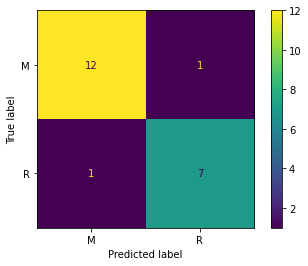

In [30]:
# Creating process instances
scaler = StandardScaler()
knn_mod = KNeighborsClassifier()

# Creating sequence of instances
operations = [('scaling', scaler),
              ('model', knn_mod)]

# Creating pipeline object
from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)

# Create param_grid
param_grid = {'model__n_neighbors':range(1,30)}

# Create Grid Search CV object
from sklearn.model_selection import GridSearchCV
grid_model = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit & find best estimator:
grid_model.fit(X_train, y_train)
display(grid_model.best_estimator_.get_params())

# Predict & Measure Performance
y_pred = grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(grid_model, X_test, y_test)
print(classification_report(y_test, y_pred))

In [31]:
grid_model.cv_results_['param_model__n_neighbors']

masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False],
       fill_value='?',
            dtype=object)

[Text(0.5, 0, 'k='), Text(0, 0.5, 'Error Rate')]

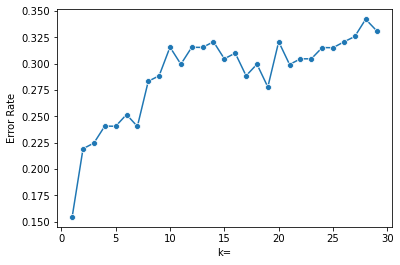

In [32]:
# Plot results from CV
sns.lineplot(x=grid_model.cv_results_['param_model__n_neighbors'],
             y=1-grid_model.cv_results_['mean_test_score'],
             marker='o').set(xlabel='k=', ylabel='Error Rate')

The End